<br><br>

## 幸福指数

本笔记本纯粹是一项探索性数据分析，目的是看看我能否找出使一个国家感到幸福或不幸的因素。为此，我将分析和探索**2021年的世界幸福指数**，以及**自2005年以来的历史世界幸福指数数据**。

我希望在这个过程中能学到一些东西，也希望读到这篇文章的任何人也能如此。

另外，我会引入人口数据来研究这是否与幸福水平有明显的联系。

我还将探索各国是否能够随着时间的推移改善其排名，或者这些排名是否基本保持不变。

最后，我将使用K均值和肘部方法正式地对我们的数据进行聚类，以查看我们是否可以根据数据集中各种指标的分数将国家分组在一起。

<br><br>

<br><br>

## 准备工作
安装必要的包

```
pip3 install pywaffle, geopandas, pycountry 
```

**本文代码较多， 只展示部分代码，完整的代码&数据，请前往textdata.cn下载**。


<br> 导入数据

In [27]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt


#get data
df = pd.read_csv('data/world-happiness-report-2021.csv')
df2 = pd.read_csv('data/world-happiness-report.csv')
pop = pd.read_csv('data/population_by_country_2020.csv')

safety = df.copy()

# 统一不同数据中的字段名renaming columns for easier merge later
df.rename(columns={'Country name': 'Country'}, inplace=True)
df2.rename(columns={'Country name': 'Country'}, inplace=True)
pop.rename(columns={'Country (or dependency)': 'Country'}, inplace=True)

#might use later 
temporal = df2.groupby(['year','Country'])['Life Ladder'].mean().unstack().T
temporal = temporal.fillna(0).astype(int)

# colours
low_c = '#dd4124'
high_c = '#009473'
plt.rcParams["font.family"] = "monospace"

## 初始概览

In [28]:
# inspiration ; https://www.kaggle.com/gaetanlopez/how-to-make-clean-visualizations
# changed code signif.

fig = plt.figure(figsize=(6,3),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(1.167,0.85,"2021 World Happiness Index",color='#323232',fontsize=28, fontweight='bold', fontfamily='sanserif',ha='center')
ax0.text(1.13,-0.35,"stand-out facts",color='lightgray',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')

ax0.text(0,0.4,"Finland",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.1,"Happiest",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(0.77,0.4,"9 of top 10",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0.75,0.1,"in Europe",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(1.5,0.4,"7 of bottom 10",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(1.5,0.1,"in Africa",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(2.25,0.4,"Afghanistan",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.25,0.1,"Unhappiest",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
import matplotlib.lines as lines
l1 = lines.Line2D([0.15, 1.95], [0.67, 0.67], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l1])
l2 = lines.Line2D([0.15, 1.95], [0.07, 0.07], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l2])
    
plt.show()

findfont: Font family 'sanserif' not found.
findfont: Font family 'sanserif' not found.
findfont: Font family 'sanserif' not found.
findfont: Font family 'sanserif' not found.
findfont: Font family 'sanserif' not found.


<br><br>

## 世界上最幸福的国家是哪些？

对我来说，'**幸福**'似乎是一个个体化的指标，很难进行概括。然而，有些国家在幸福指数排名中表现始终稳定。

我们还注意到，前10名中有9个是欧洲国家，而后10名中有7个是非洲国家。

让我们看看目前位于列表顶端的国家，以及那些位于底部的国家。

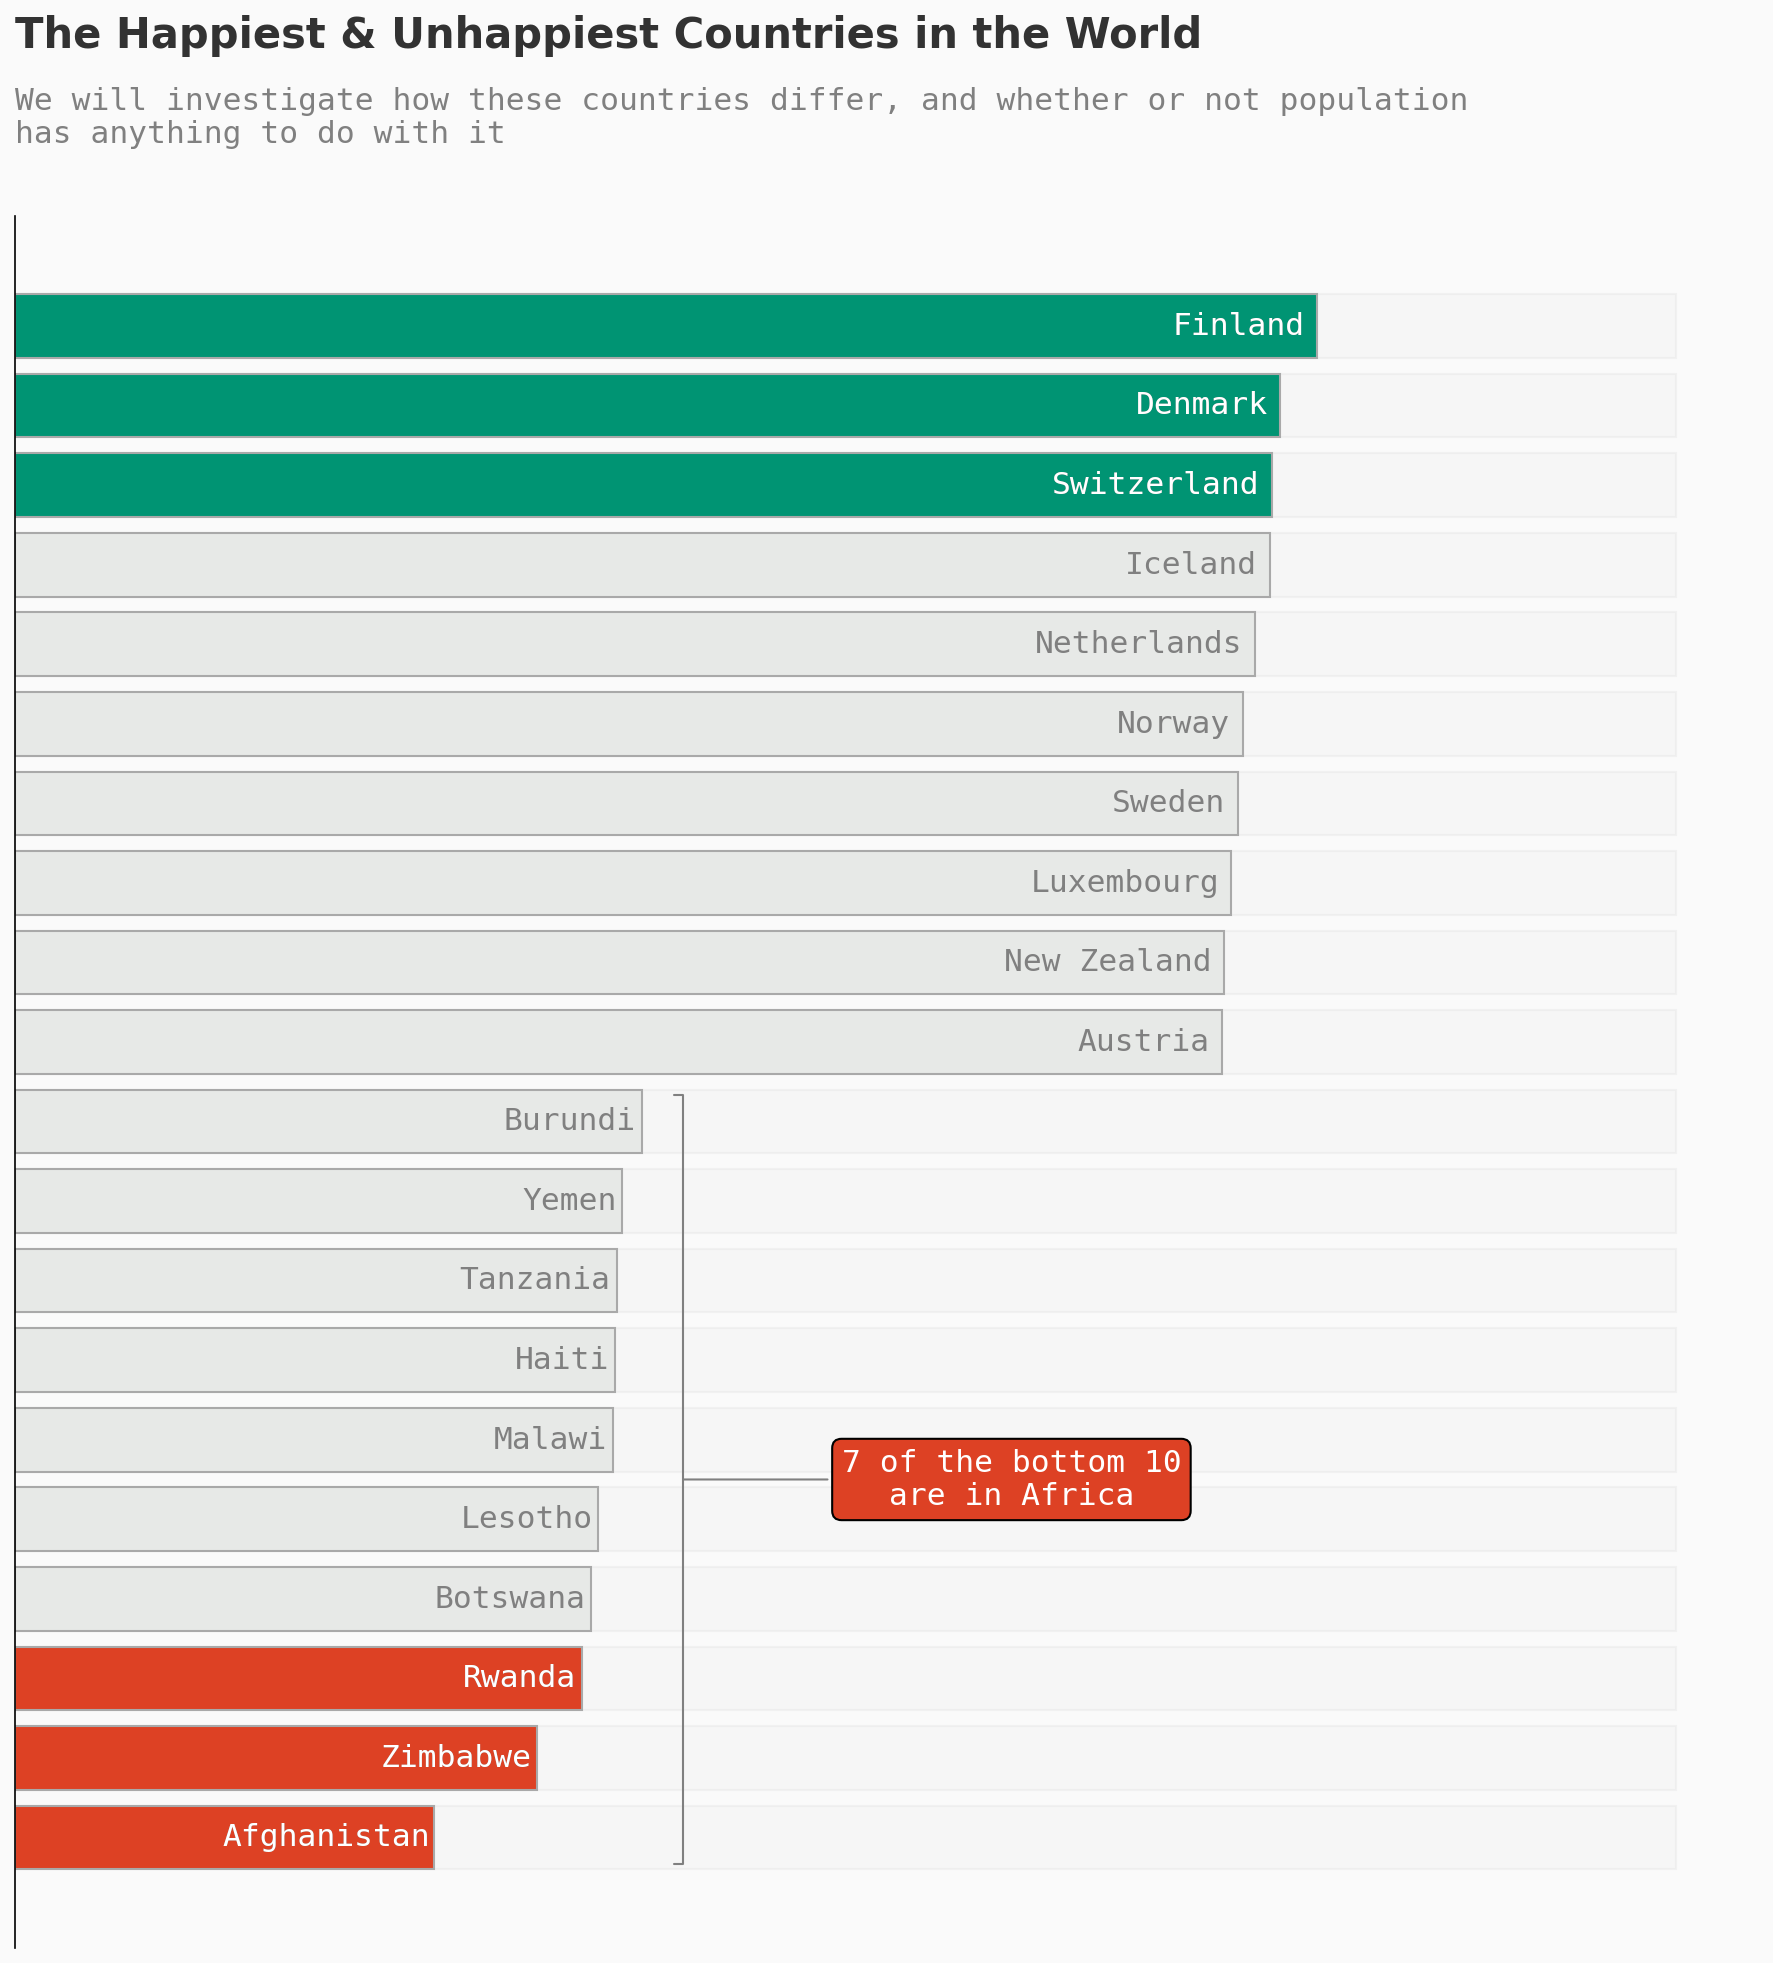

In [29]:
past_winners = df2.loc[df2.groupby("year")["Life Ladder"].idxmax()]
past_bottom = df2.loc[df2.groupby("year")["Life Ladder"].idxmin()]

hap = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=False)[:10]
unhap = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=True)[:10]
top_bottom = pd.concat([hap, unhap]).sort_values(ascending=True)

fig = plt.figure(figsize=(15,15),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


# Plots 
# Happiest
data = top_bottom

color_map = ['#e7e9e7' for _ in range(20)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight
color_map[17] = color_map[18] = color_map[19] =  high_c 
#base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)

for i in range(0,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)

for i in range(17,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])



for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
ax0.text(0,22.5,'The Happiest & Unhappiest Countries in the World',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,21.3,'We will investigate how these countries differ, and whether or not population\nhas anything to do with it',fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

ax0.annotate('7 of the bottom 10\nare in Africa', xy=(4, 4.5), xytext=(6, 4.5), xycoords='data', 
            fontsize=15, ha='center', va='center',fontfamily='monospace',
            bbox=dict(boxstyle='round', fc=low_c),
            arrowprops=dict(arrowstyle='-[, widthB=12.3, lengthB=0.3', lw=1, color='gray'), color='white')

plt.show()

<br>
现在让我们把前10名和后10名并排放置，以便从另一个角度观察。

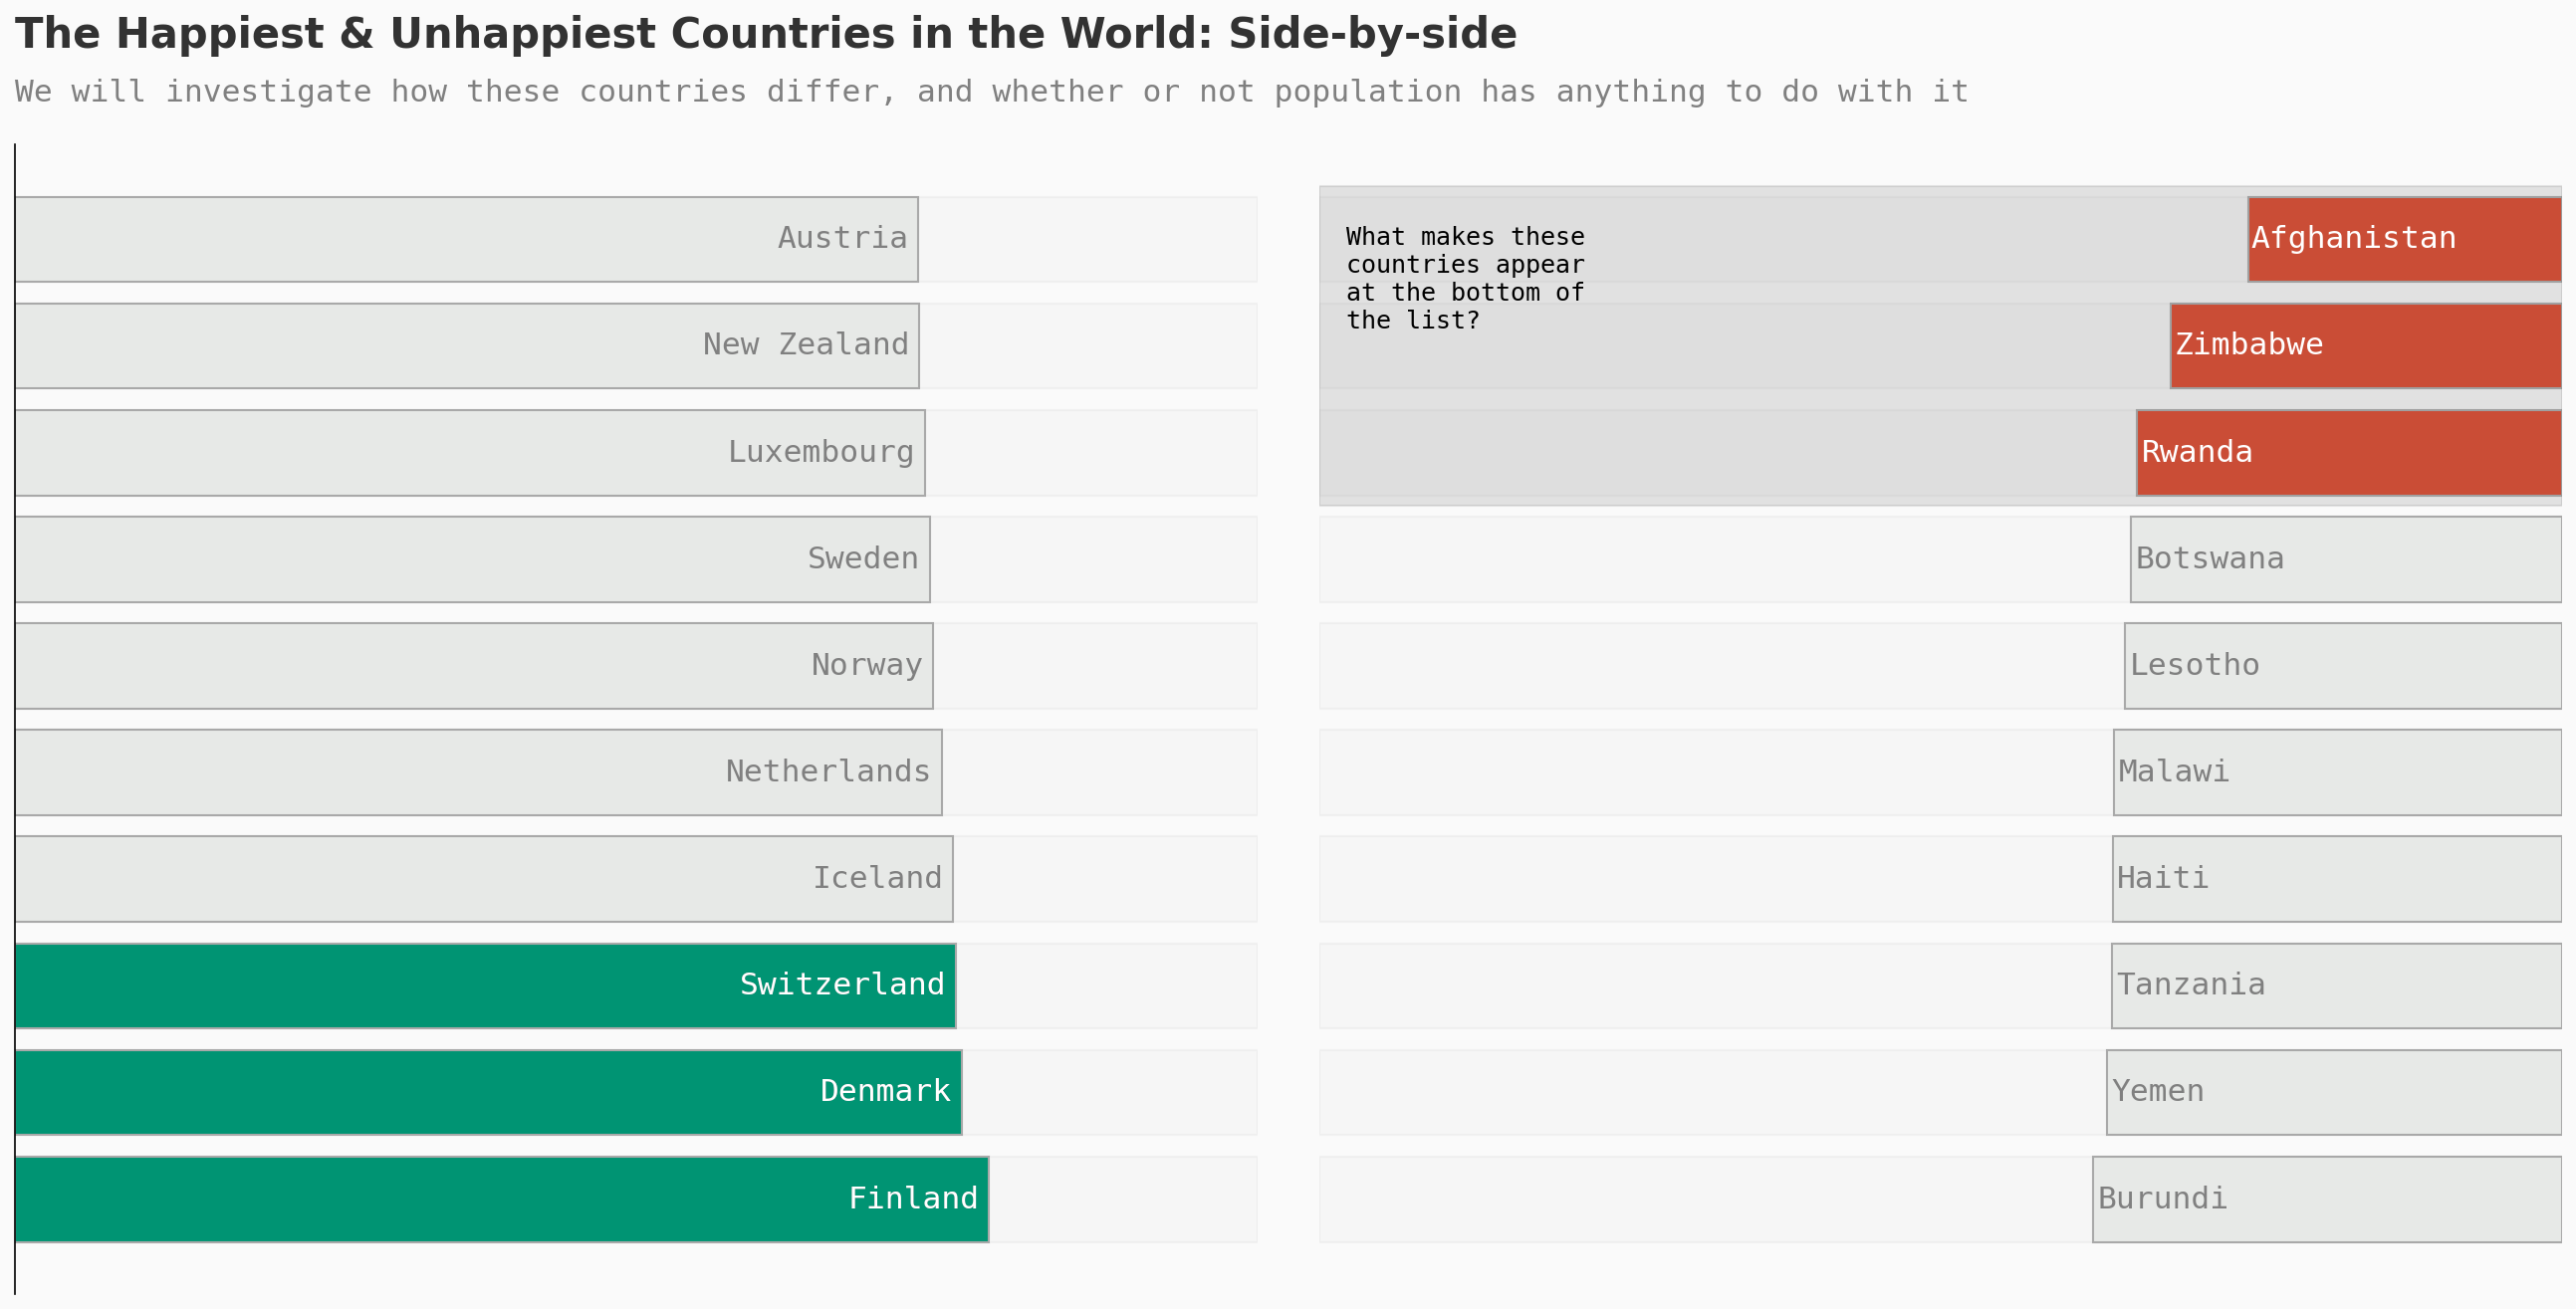

In [30]:
fig = plt.figure(figsize=(22,10),dpi=150)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 


# Plots 
# Happiest
data = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=False)[:10]


color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  high_c # color highlight

#base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


#annotations
#for i in data.index:
 #   ax.annotate(f"{round(data[i],3)}", 
  #                 xy=(data[i] + 0.5,i), #i like to change this to roughly 5% of the highest cat
   #                va = 'center', ha='right',fontweight='light', fontfamily='serif',fontsize=12)
for i in range(0,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    
# Unhappiest

data = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=True)[:10]

color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight

#base
ax1.barh(data.index[::-1], 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax1.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


#annotations
#for i in data.index:
 #   ax.annotate(f"{round(data[i],3)}", 
  #                 xy=(data[i] + 0.5,i), #i like to change this to roughly 5% of the highest cat
   #                va = 'center', ha='right',fontweight='light', fontfamily='serif',fontsize=12)
for i in range(7,10):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
# diff color text
for i in range(0,7):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)

    


# Remove border from plot

for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
for s in ['top', 'bottom', 'right','left']:    
    ax1.spines[s].set_visible(False)
    


    
ax0.set_xlim(0,10)
ax1.set_xlim(10,0)
    
# ax labels off

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])

ax0.text(0,10.8,'The Happiest & Unhappiest Countries in the World: Side-by-side',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,10.3,'We will investigate how these countries differ, and whether or not population has anything to do with it',fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

# rect
from matplotlib.patches import Rectangle
X, Y = 0, 6.5


ax1.add_patch(Rectangle((X, Y), 10, 3,alpha=0.2, edgecolor='gray',facecolor='gray'))

fig.text(0.53,0.72,
        
'''
What makes these 
countries appear 
at the bottom of
the list?

''',color='black',fontfamily='monospace',fontsize=12)


plt.show()

<br>

乍一看，我们发现世界上最幸福的许多国家确实位于欧洲。

另一个额外的观察是，位于前10名的欧洲国家都是北欧国家。

In [31]:
happiness_mean = df['Ladder score'].mean()

df['lower_happy'] = df['Ladder score'].apply(lambda x: 0 if x < happiness_mean else 1)

<br><br>

## 这种情况经常发生吗？
稍后我将更深入地探索时间上的变化，但现在，让我们看一下这些年来排在前20名的国家。

这个图展示了从2005年至今，前20名国家的所有分数，特别突出了它们的平均分和2021年的分数。

值得注意的是，尽管有疫情的影响，许多国家在2021年的分数比他们的平均分还要高。

尽管这些分数确实有所不同，但它们仍然相对较高。

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


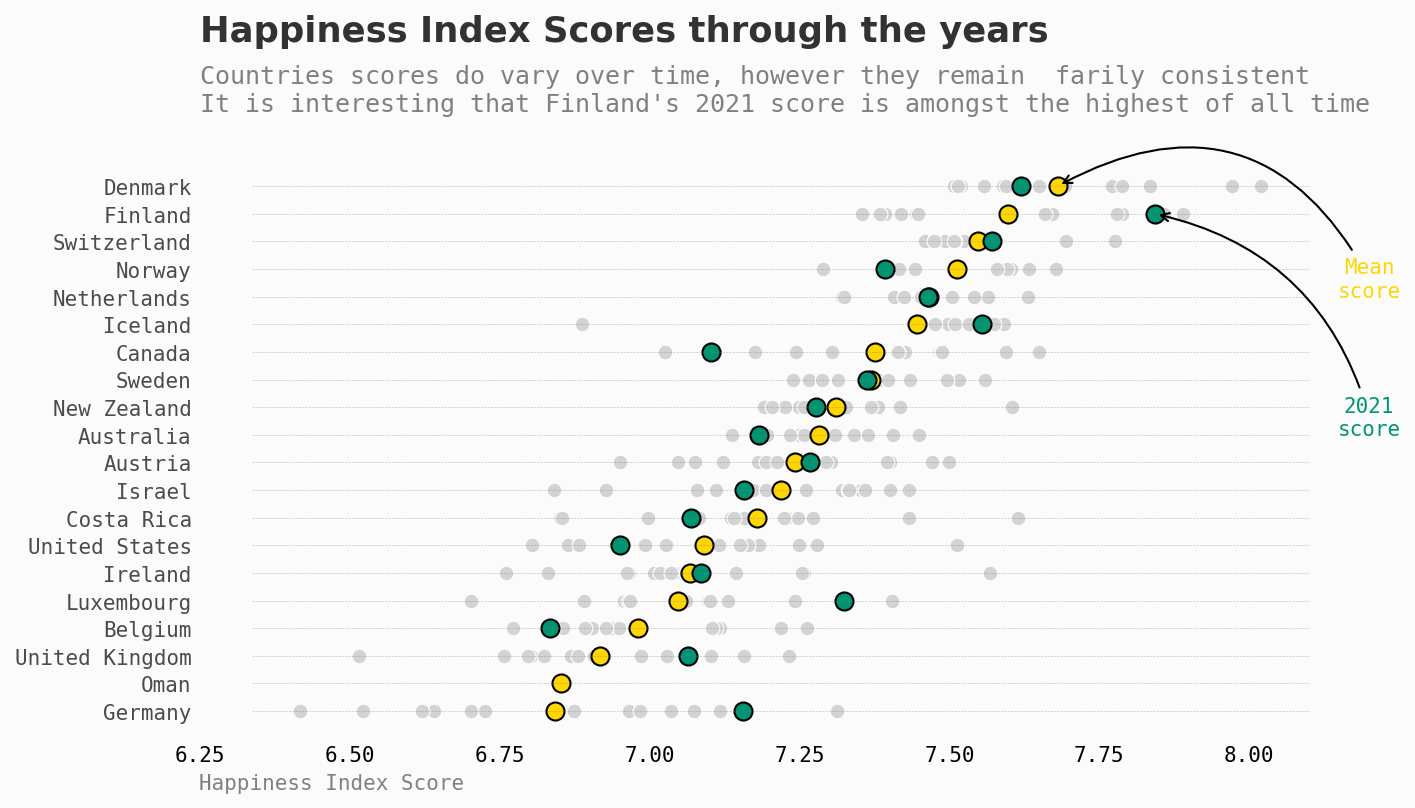

In [32]:
import seaborn as sns


background = "#fbfbfb"
fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color
ax.set_facecolor(background)

# Reduced list as too many to show all at once 
top_list_ = df2.groupby('Country')['Life Ladder'].mean().sort_values(ascending=False).reset_index()[:20].sort_values(by='Life Ladder',ascending=True)


plot = 1
for country in top_list_['Country']:
    mean = df2[df2['Country'] == country].groupby('Country')['Life Ladder'].mean()
    # historic scores
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x='Life Ladder',color='lightgray',s=50,ax=ax)
    # mean score
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x=mean,color='gold',ec='black',linewidth=1,s=75,ax=ax)
    #2021 score
    sns.scatterplot(data=df[df['Country'] == country], y=plot, x='Ladder score',color=high_c,ec='black',linewidth=1,s=75,ax=ax)   
    plot += 1


ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['Country'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Happiness Index Score",fontfamily='monospace',loc='left',color='gray')


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.hlines(y=top_list_.index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)
ax.text(6.25, Yend+4.3, 'Happiness Index Scores through the years', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax.text(6.25, Yend+0.75,
'''
Countries scores do vary over time, however they remain  farily consistent
It is interesting that Finland's 2021 score is amongst the highest of all time
''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.annotate('2021\nscore', xy=(7.842, 19), xytext=(8.2, 11),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.3"), fontsize=10,fontfamily='monospace',ha='center', color=high_c)

plt.annotate('Mean\nscore', xy=(7.6804, 20), xytext=(8.2, 16),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.5"), fontsize=10,fontfamily='monospace',ha='center', color='gold')


plt.show()

<br><br>

## 为什么会有差异？
我们现在了解到，北欧国家一直位居榜首。

让我们更仔细地探究一下欧洲与世界其他地区之间的这些差异。



findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


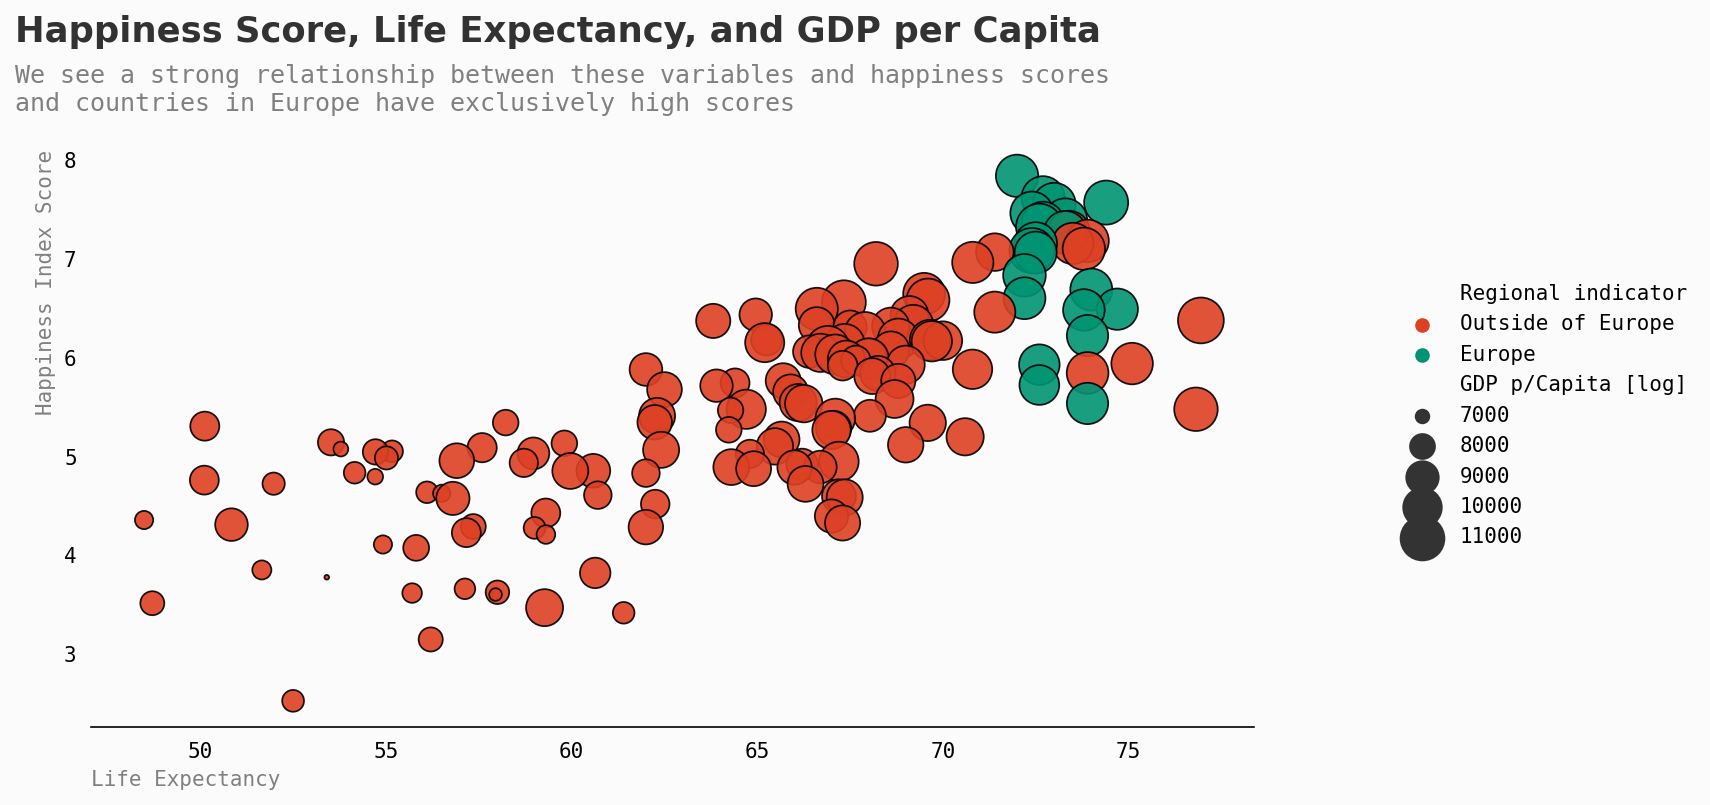

In [33]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Healthy life expectancy', y='Ladder score',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',size=df["Logged GDP per capita"]*1000, legend=True, sizes=(5, 500))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(45,9.2,'Happiness Score, Life Expectancy, and GDP per Capita',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(45,8.5,'We see a strong relationship between these variables and happiness scores\nand countries in Europe have exclusively high scores',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('GDP p/Capita [log]')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

幸福程度较高的国家往往是那些预期寿命更长、GDP更高的国家。这也基本上包括了西欧。

现在让我们明确地关注一下非洲...

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


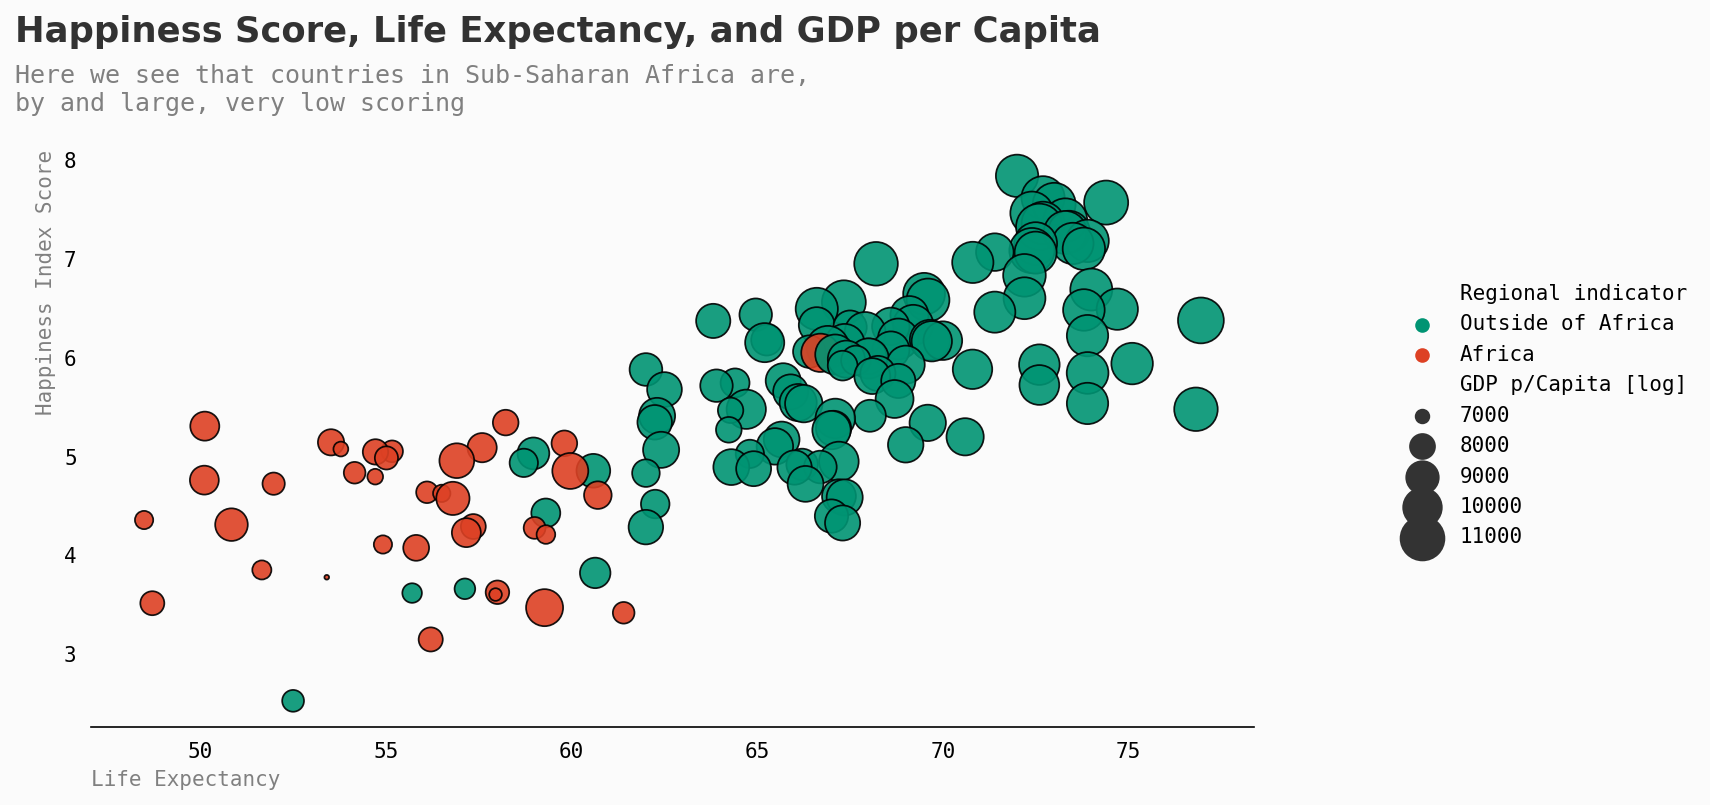

In [34]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [high_c,low_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Healthy life expectancy', y='Ladder score',hue=df['Regional indicator'] == 'Sub-Saharan Africa',palette=cmap, alpha=0.9,ec='black',size=df["Logged GDP per capita"]*1000, legend=True, sizes=(5, 500))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(45,9.2,'Happiness Score, Life Expectancy, and GDP per Capita',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(45,8.5,'Here we see that countries in Sub-Saharan Africa are,\nby and large, very low scoring',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')



L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Africa')
L.get_texts()[2].set_text('Africa')
L.get_texts()[3].set_text('GDP p/Capita [log]')

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

总体而言，非洲国家有更低的预期寿命、更低的GDP，最终也有更低的幸福指数分数。

<br><br>
## 其他因素
因此，GDP和预期寿命是影响因素。还有什么其他因素可以考虑呢？

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


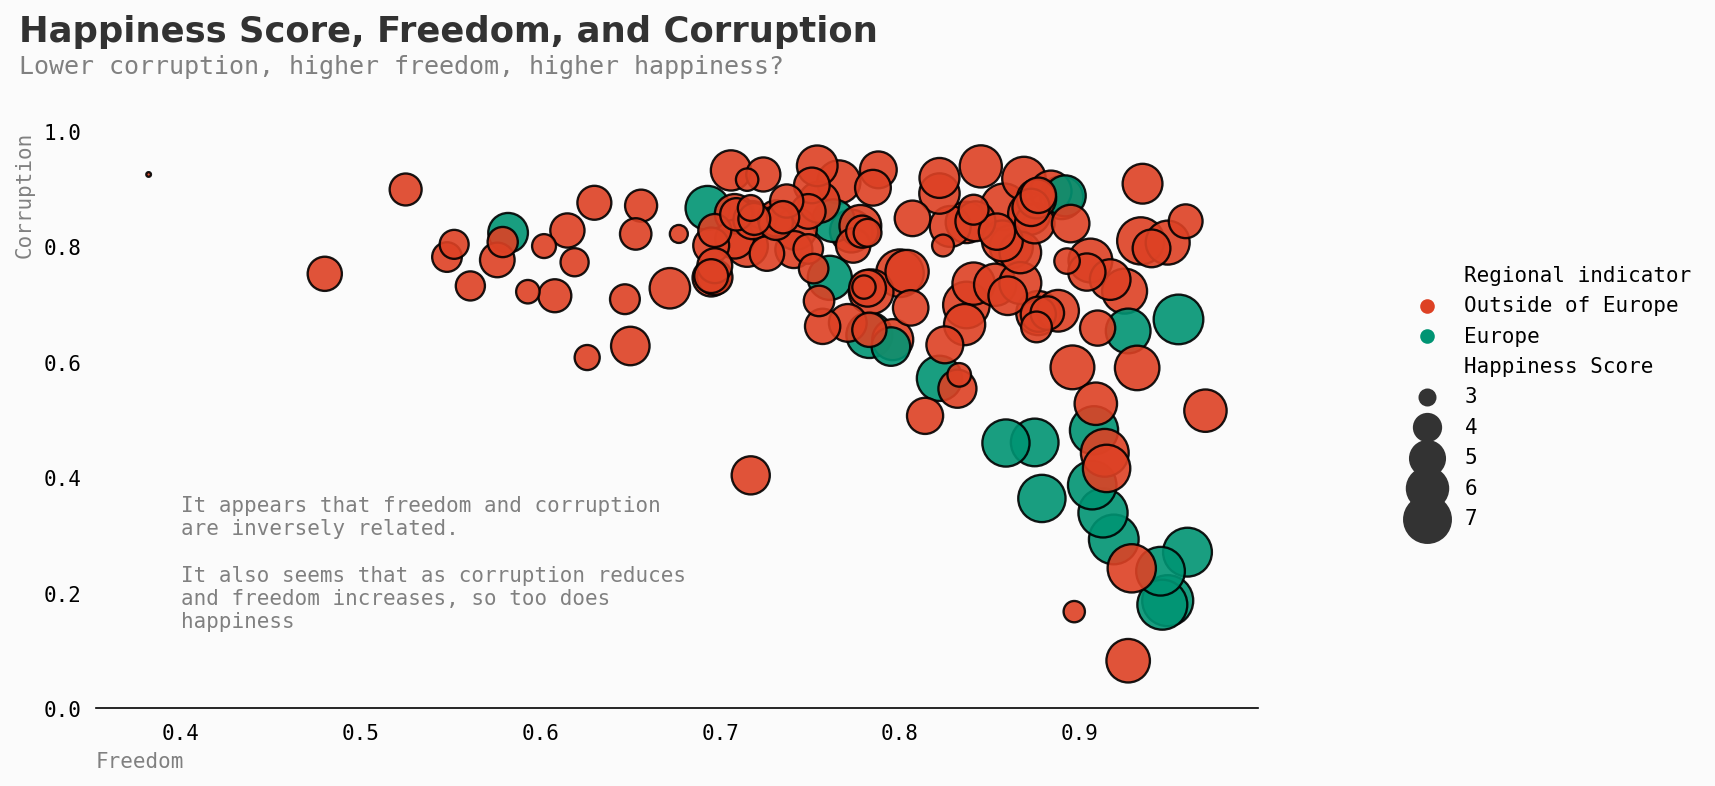

In [35]:
import numpy as np

background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Freedom to make life choices', y='Perceptions of corruption',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',size=df["Ladder score"], legend=True, sizes=(5, 600))

ax.set_xlabel("Freedom",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Corruption",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Happiness Score')

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end+0.2, 0.2))



ax.text(0.31,1.155,'Happiness Score, Freedom, and Corruption',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(0.31,1.1,'Lower corruption, higher freedom, higher happiness?',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

ax.text(0.4,0.1,
'''
It appears that freedom and corruption
are inversely related. 

It also seems that as corruption reduces
and freedom increases, so too does
happiness
''',fontfamily='monospace',fontsize=10,color='gray')

plt.show()

正如我在图中指出的，自由和腐败是成反比的关系：更高的腐败通常伴随着更低的自由度。

然而，有趣的是需要注意的是，几个欧洲国家也有高度认知的腐败水平。

<br><br>

## 大陆视角
让我们将这些国家按照各自所属的大陆分类，看看我们能否了解更多。

当然，我们预期西欧会排名很高，但是在幸福排名中，还有没有其他表现特别好或特别差的大陆？

In [36]:
continent_score = df.groupby('Regional indicator')[['Healthy life expectancy','Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Ladder score']].mean().reset_index()

background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]


color_map = ['#e7e9e7' for _ in range(10)]
color_map[9] =  high_c # color highlight
color_map[5] =  high_c
color_map[8] =  low_c
color_map[6] =  low_c


ax.set_facecolor(background)
sns.scatterplot(data=continent_score, x=continent_score['Healthy life expectancy'], y=continent_score['Ladder score'],hue=continent_score['Regional indicator'], alpha=0.9,ec='black',palette=color_map,size=df["Ladder score"], legend=False, sizes=(5, 600))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(55,7.5,'Happiness Score & Life Expectancy by Continent',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(55,7.3,'There are clear distinctions, with four stand-out continents',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')



L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

for i, txt in enumerate(continent_score['Regional indicator']):
    ax.annotate(txt, (continent_score['Healthy life expectancy'][i]+0.5, continent_score['Ladder score'][i]),fontfamily='monospace')


    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


可以清晰地看到有三个大陆群体。稍后将对此进行更多讨论...

撒哈拉以南非洲和南亚的分数最低。而西欧以及北美和澳新（ANZ）则遥遥领先，位于榜单的顶端。

In [44]:
continent_score = df.groupby('Regional indicator')[['Healthy life expectancy','Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Ladder score']].mean().mean(axis=1).sort_values(ascending=True)[:10]

df_bottom = df.groupby('Country')[['Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Social support','Ladder score']].mean().sort_values(by='Ladder score',ascending=True)[:10]

df_bottom['Logged GDP per capita'] = df_bottom['Logged GDP per capita']/10
df_bottom['Ladder score'] = df_bottom['Ladder score']/5

categorical = [var for var in df.columns if df[var].dtype=='O']
continuous = [var for var in df.columns if df[var].dtype!='O']

#refined
continuous = ['Logged GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

<br><br>

## 高于和低于平均幸福水平的差异

让我们一次绘制多个特征，按照平均幸福水平进行划分。如往常一样，最幸福的国家以绿色显示。

In [45]:

background_color = '#fbfbfb'
fig = plt.figure(figsize=(12, 6), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.5)


plot = 0
for row in range(0, 2):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

Yes = df[df['lower_happy'] == 1]
No = df[df['lower_happy'] == 0]

for variable in continuous:
        sns.kdeplot(Yes[variable], ax=locals()["ax"+str(plot)], color=high_c,ec='black', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(No[variable],ax=locals()["ax"+str(plot)], color=low_c, shade=True, ec='black',linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable, fontfamily='monospace')
        plot += 1
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.5), 'Differences between happy & unhappy countries', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax0.text(Xstart, Yend+(Yend*0.25), 'There are large differences, with GDP & Social Support being clear\nperhaps more interesting though, unhappy countries appear to be more generous', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.show()

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


上面的图表确认了我们之前看到的一些内容，并带有一些值得注意的特点，比如社会支持。

在不太幸福的国家中，慷慨度被认为更高，这非常有趣。
<br><br>

## 全球视角
我们现在已经看到了基于多个因素不同国家之间明显的差异。

现在让我们从全球角度来看这个问题。

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


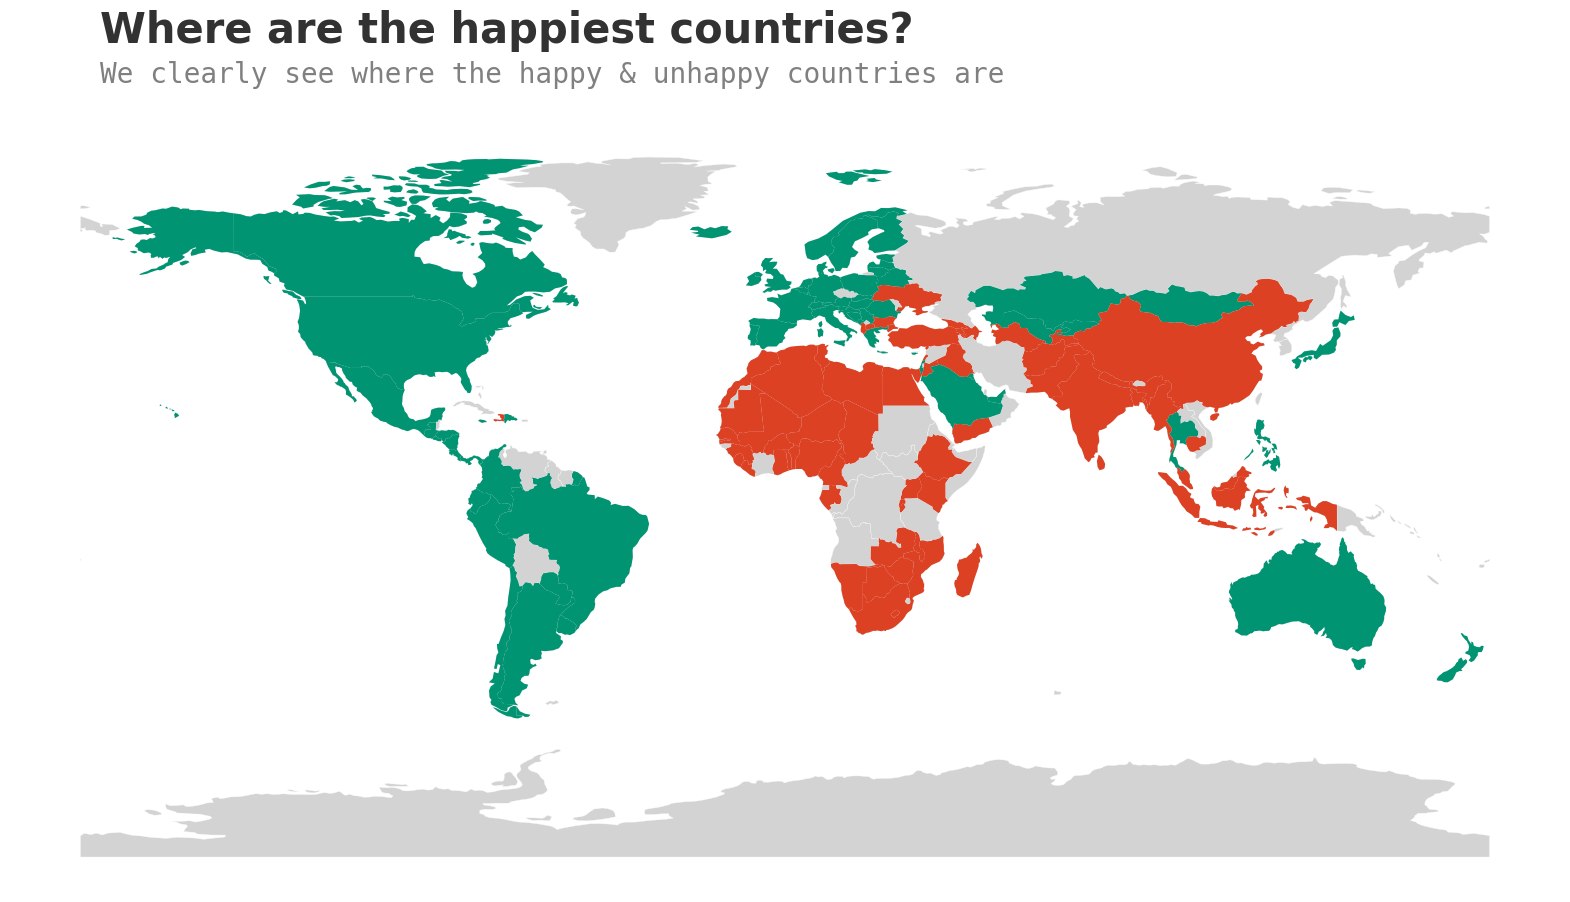

In [49]:
import geopandas
import matplotlib.colors
import pycountry 

#data prep

geo_temp = df



#source: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
geo_temp['CODE']=alpha3code(geo_temp['Country'])


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge=pd.merge(world,geo_temp,on='CODE')


###

# Custom colour map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [low_c,high_c])

ax = world.plot(figsize=(20,15), linewidth=0.25, edgecolor=background_color, color='lightgray')
ax.axis('off')
ax.set_facecolor(background_color)
merge.plot(column='lower_happy',figsize=(20, 15),legend=False,cmap=cmap,ax=ax)


ax.text(-175,112,'Where are the happiest countries?',fontsize=30,fontweight='bold',fontfamily='sansserif',color='#323232')
ax.text(-175,102,'We clearly see where the happy & unhappy countries are',color='gray',fontfamily='monospace',fontsize=20)

plt.show()

这张图确认了我们之前的发现，南亚和非洲处于红色区域。

但它也突出了我们可以进一步调查的地区。例如，中国和印度都在红色区域，它们的人口都超过了10亿。我们能否研究人口与幸福水平之间的关系？
<br><br>

## 人口
让我们引入更多的因素——比如人口。

这是否会影响幸福水平？

In [52]:
# merge on country
df = pd.merge(df, pop, on='Country')
# removing NA value

df=df[df['Urban Pop %'] != 'N.A.']

# Changing data types, removing % strings etc

df['Urban Pop %'] = df['Urban Pop %'].str.rstrip('%').astype('float') / 100.0
df['World Share'] = df['World Share'].str.rstrip('%').astype('float') / 100.0
df['Yearly Change'] = df['Yearly Change'].str.rstrip('%').astype('float') / 100.0
df['Fert. Rate'] = df['Fert. Rate'].astype('float')
df['Med. Age'] = df['Med. Age'].astype('float')

# Adding in some bins

df['Count'] = 1
df['pop_quantile'] = pd.qcut(df['Population (2020)'], 10, labels=False)
df['density_quantile'] = pd.qcut(df['Density (P/Km²)'], 10, labels=False)

merge_safety = df

background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Med. Age', y='Ladder score',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',linewidth=1.3,size=df["Population (2020)"]*1000, legend=True, sizes=(5, 2500))

ax.set_xlabel("Median age",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,9.2,'Happiness Score, Median Age, and Population',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(start,8.5,'It appears that the happier countries have older populations,\nand less people in general',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Population')
L.get_texts()[4].set_text('   25m')
L.get_texts()[5].set_text('   50m')
L.get_texts()[6].set_text('   75m')
L.get_texts()[7].set_text('   100m')
L.get_texts()[8].set_text('   125m+')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


我们清晰地看到，更幸福的国家往往年龄更大，人口更少。

我加入了欧洲作为参考。

那么生育率呢？

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


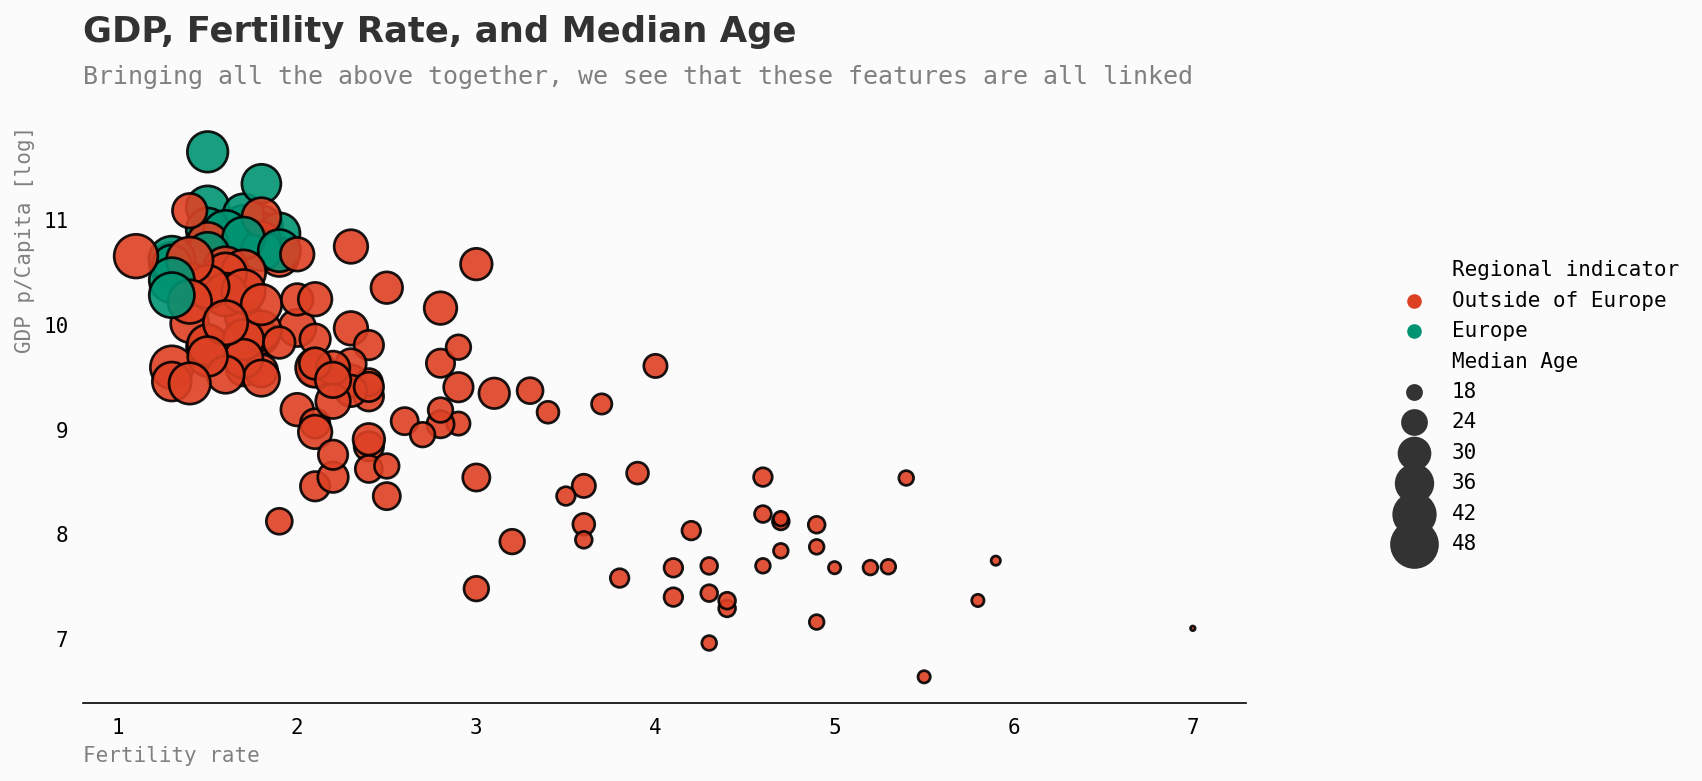

In [53]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Fert. Rate', y='Logged GDP per capita',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',linewidth=1.3,size=df["Med. Age"], legend=True, sizes=(5, 500))

ax.set_xlabel("Fertility rate",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("GDP p/Capita [log]",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,12.7,'GDP, Fertility Rate, and Median Age',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(start,12.3,'Bringing all the above together, we see that these features are all linked',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Median Age')
#L.get_texts()[4].set_text('   25m')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

正如我所怀疑的，更幸福的国家通常也有更少的孩子。这很可能是由于可以更容易地获得避孕方法。

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


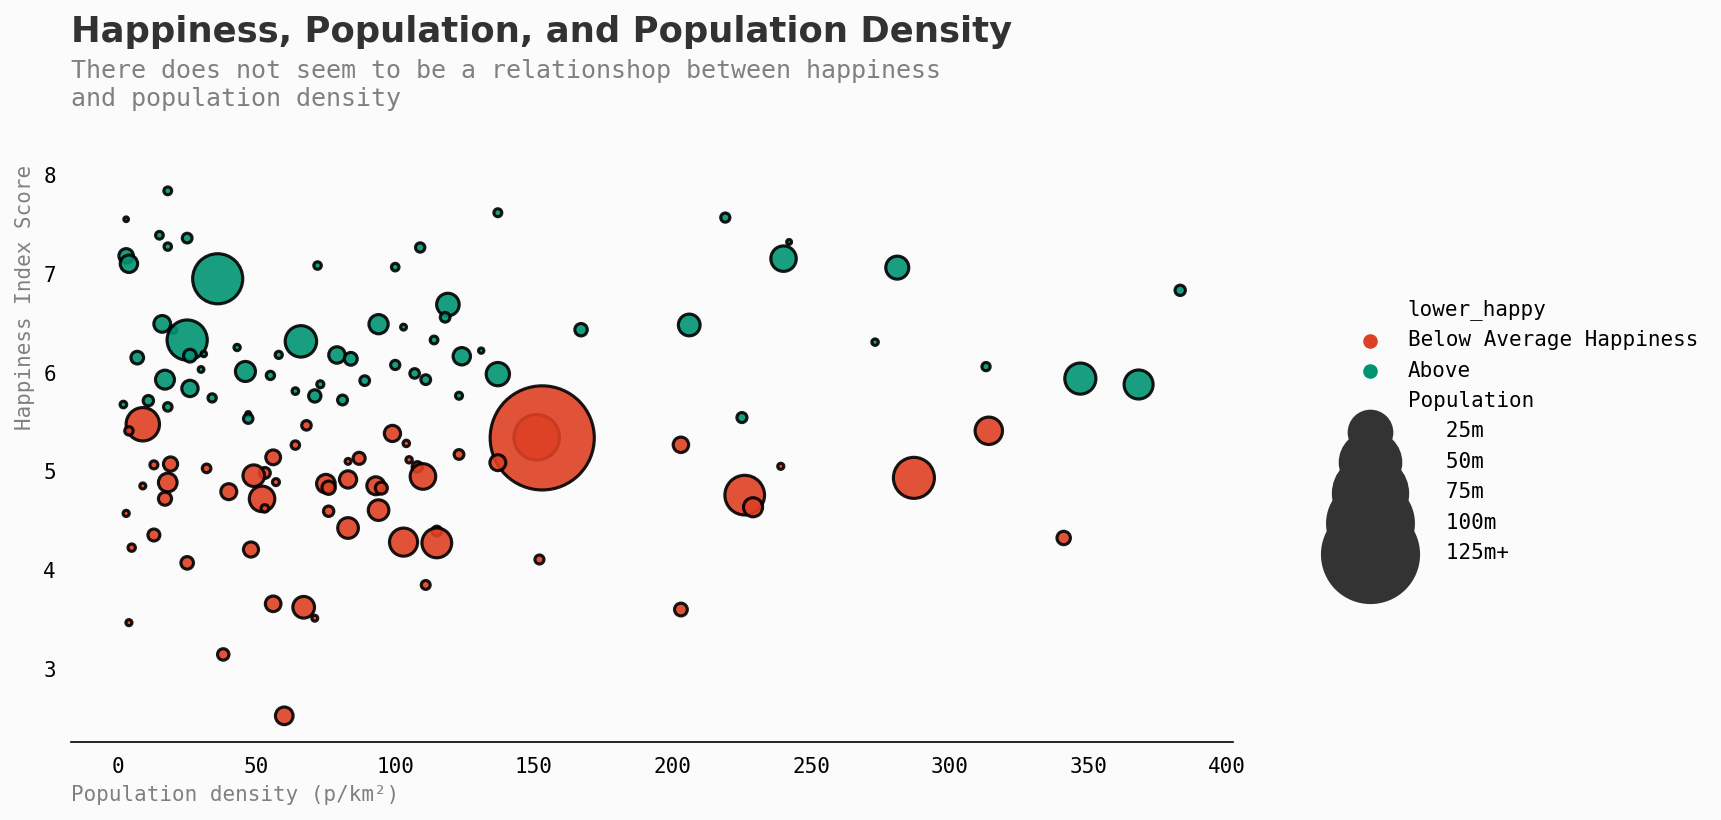

In [54]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

ax.set_facecolor(background)

cmap = [low_c,high_c]

df_plot = df[df['density_quantile'] <9 ]

sns.scatterplot(data=df_plot, x="Density (P/Km²)", y="Ladder score", hue='lower_happy',palette=cmap, size=df_plot["Population (2020)"]*1000, legend=True, sizes=(5, 2500),alpha=0.9,ec='black',linewidth=1.5)

ax.set_xlabel("Population density (p/km²)",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,9.35,'Happiness, Population, and Population Density',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax.text(start,8.7,'There does not seem to be a relationshop between happiness\nand population density',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')

L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Below Average Happiness')
L.get_texts()[2].set_text('Above')
L.get_texts()[3].set_text('Population')
L.get_texts()[4].set_text('   25m')
L.get_texts()[5].set_text('   50m')
L.get_texts()[6].set_text('   75m')
L.get_texts()[7].set_text('   100m')
L.get_texts()[8].set_text('   125m+')

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

我很惊讶人口密度并不影响幸福感——尽管这可能是因为个人偏好！

<br><br>

## 随着时间的推移，有没有变化？
不快乐的人会变得更快乐吗？

这仅仅是一个时间点的快照吗？还是这些趋势更加持久？

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


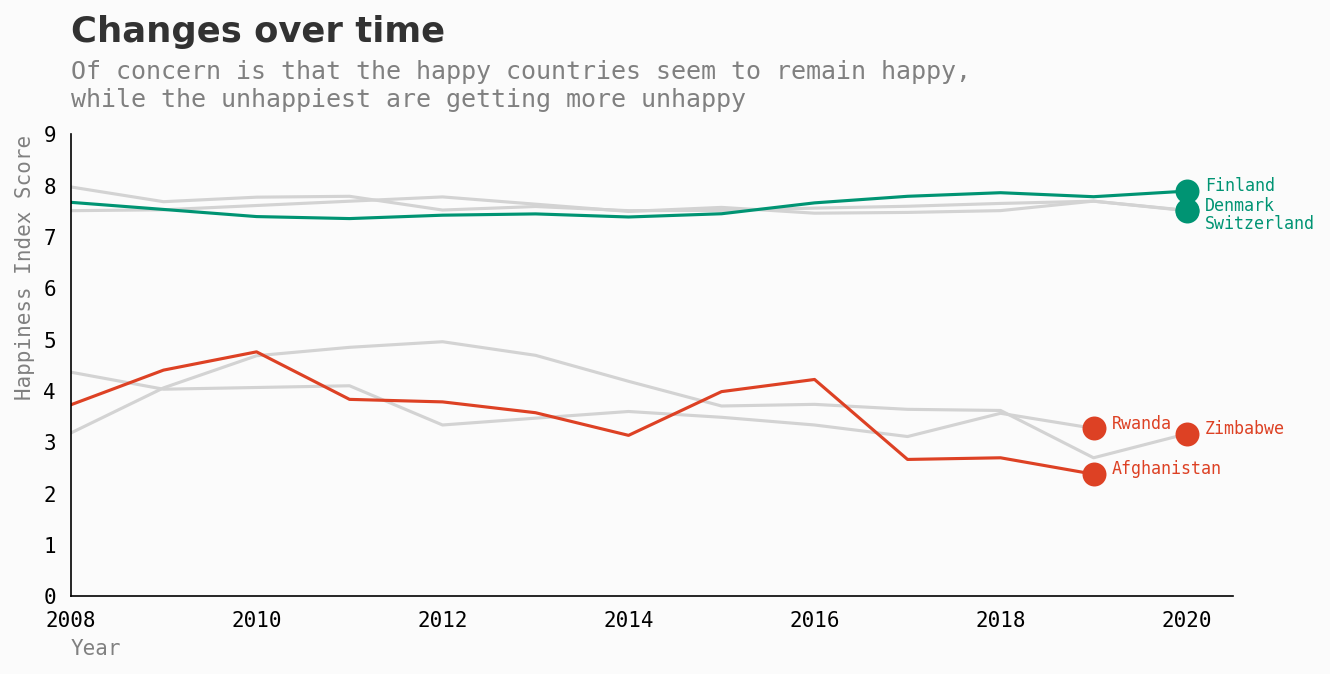

In [55]:
import matplotlib.dates as mdates


fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
    
ax0.set_xlabel("Year",fontfamily='monospace',loc='left',color='gray')
ax0.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    


ax0.tick_params(axis='both', which='both', left=False, bottom=False,labelbottom=True) 

#low
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Zimbabwe')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Rwanda')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Afghanistan')], x='year', y='Life Ladder',color=low_c)

#high
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Denmark')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Switzerland')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Finland')], x='year', y='Life Ladder',color=high_c)


Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()
ax0.plot(2019,df2[(df2['Country']=='Afghanistan')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Zimbabwe')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)
ax0.plot(2019,df2[(df2['Country']=='Rwanda')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)

ax0.plot(2020,df2[(df2['Country']=='Finland')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c,markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Denmark')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c, markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Switzerland')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c, markeredgewidth=1.5)


ax0.text(2020.2,df2[(df2['Country']=='Finland')]['Life Ladder'].reset_index().iloc[-1,-1],'Finland',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Denmark')]['Life Ladder'].reset_index().iloc[-1,-1],'Denmark',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Switzerland')]['Life Ladder'].reset_index().iloc[-1,-1]-0.35,'Switzerland',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)

ax0.text(2019.2,df2[(df2['Country']=='Afghanistan')]['Life Ladder'].reset_index().iloc[-1,-1],'Afghanistan',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Zimbabwe')]['Life Ladder'].reset_index().iloc[-1,-1],'Zimbabwe',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2019.2,df2[(df2['Country']=='Rwanda')]['Life Ladder'].reset_index().iloc[-1,-1],'Rwanda',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)



ax0.yaxis.set_ticks(np.arange(0, 10, 1))
ax0.set_xlim(left = 2008, right = 2020.5)
plt.xticks(fontname = "monospace")
plt.yticks(fontname = "monospace")

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.2), 'Changes over time', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax0.text(Xstart, Yend+(Yend*0.06), 
'''
Of concern is that the happy countries seem to remain happy, 
while the unhappiest are getting more unhappy''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')



plt.show()

令人关注的是，不快乐的人依然不快乐，更糟糕的是，他们似乎变得更加不快乐。

这种趋势是持续的吗？或者某些国家的分数会随着时间的推移而提高？

让我们更多地探讨一下随时间变化的情况。

在上面，我选取了几个国家作为样本。让我们用一个斜率图来绘制他们从2007年到2020年的变化，看看我们能否从中学到什么。

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


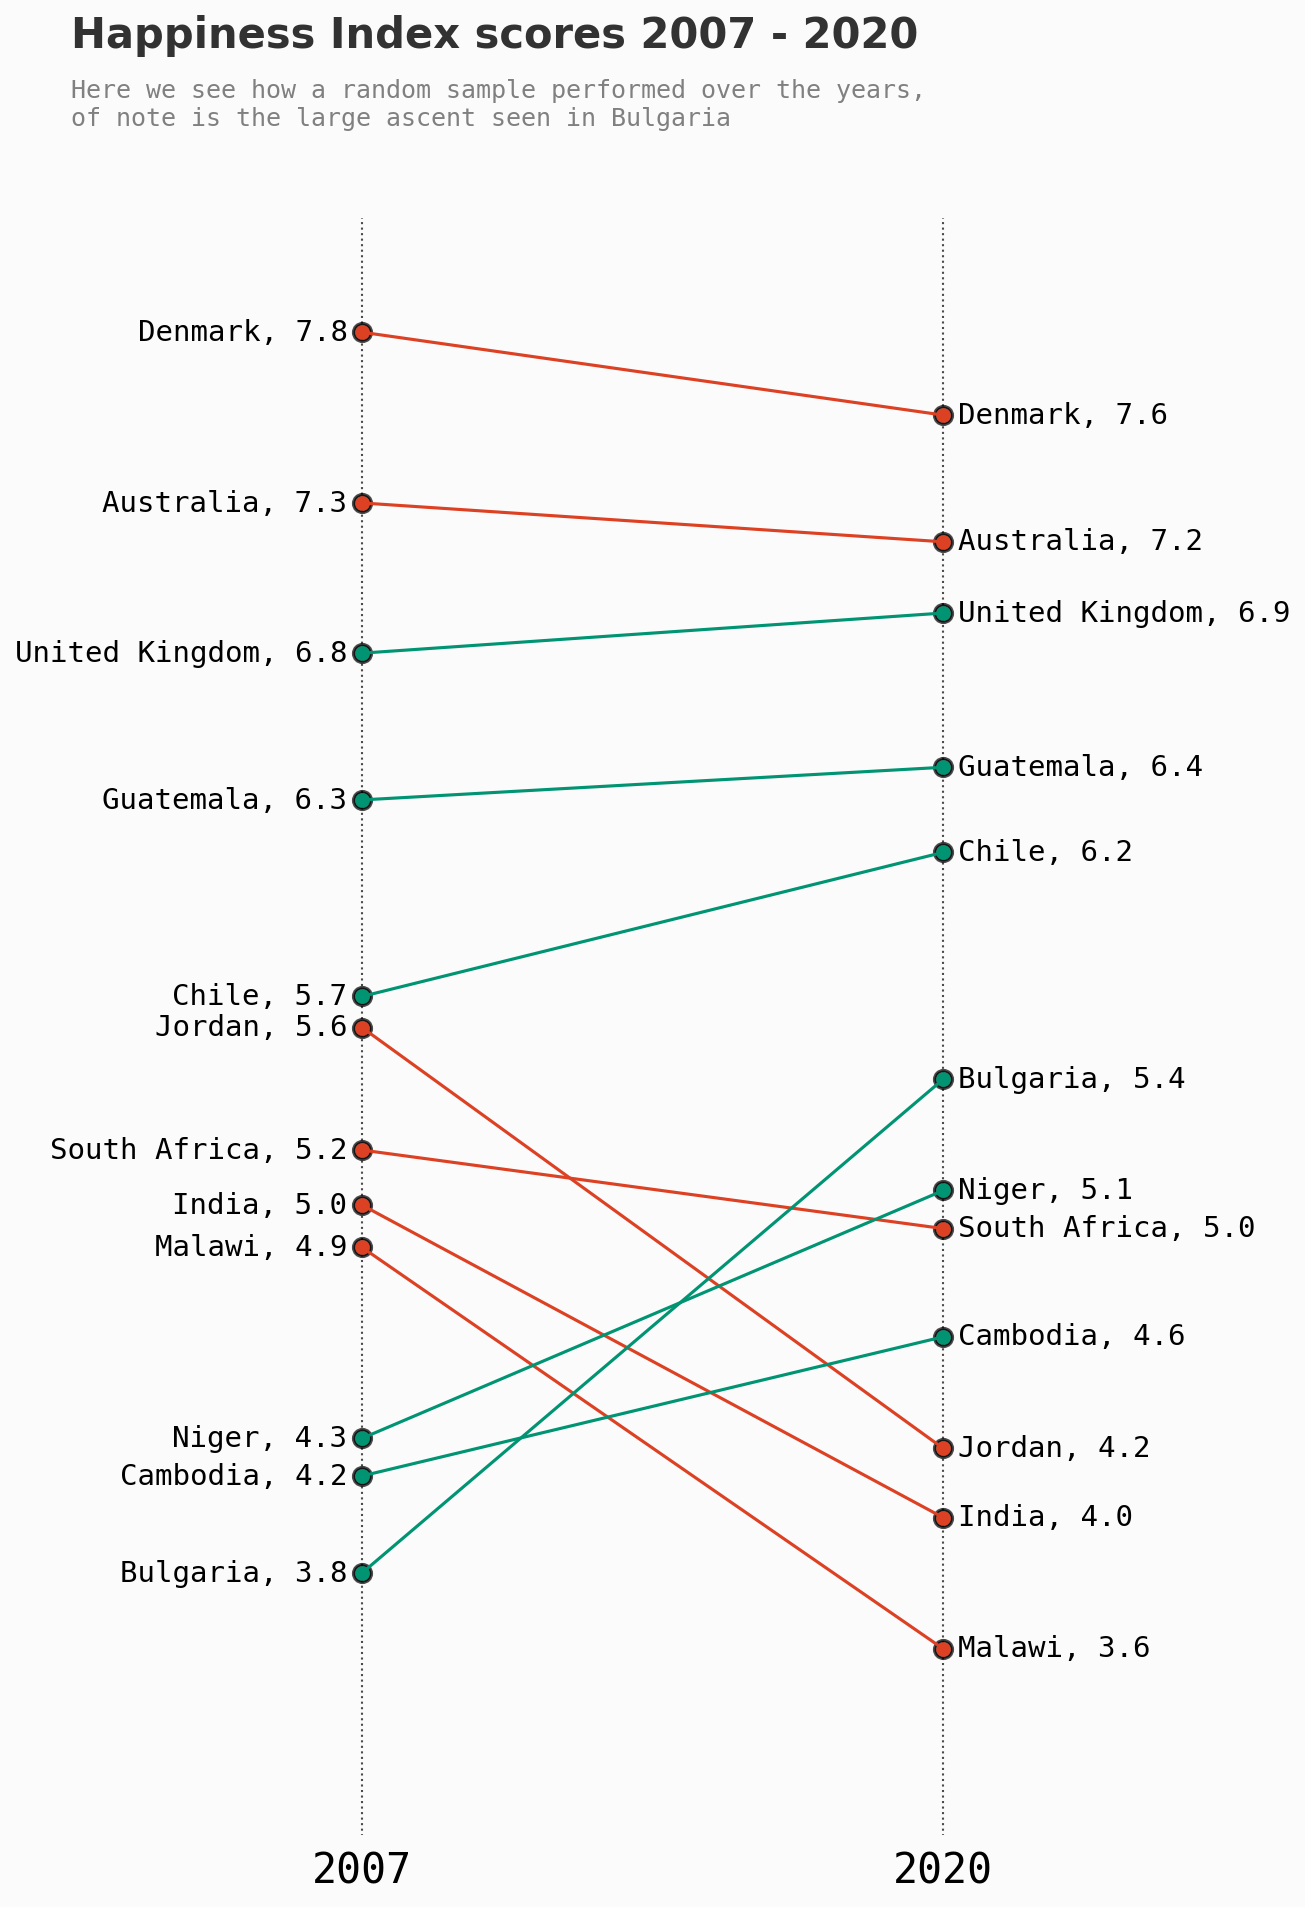

In [71]:
past = df2[['Country','Life Ladder','year']]

pres = df[['Country','Ladder score']]

pres['year'] = 2020

pres.rename(columns={'Ladder score': 'Life Ladder'}, inplace=True)

combined = pd.concat([pres, past],ignore_index=False).sort_values(by='year')


seven = combined[combined['year'] == 2007]
seven.rename(columns={'Life Ladder':'07_score'}, inplace=True)
twenty = combined[combined['year'] == 2020]
twenty.rename(columns={'Life Ladder':'20_score'}, inplace=True)

seven = seven.set_index('Country')

twenty = twenty.set_index('Country')

combined = seven.merge(twenty, on='Country', how='inner', suffixes=('_1', '_2'))

combined['change'] = combined['20_score'] - combined['07_score']

top_inc = combined.groupby('Country')['change'].mean().sort_values(ascending=False)[:10]
top_dec = combined.groupby('Country')['change'].mean().sort_values(ascending=True)[:10]
top_changes = pd.concat([top_inc, top_dec],ignore_index=False).sort_values(ascending=True)






temp = combined.groupby('Country')[['07_score','20_score','change']].mean().sort_values(by='07_score',ascending=False).reset_index()

sample = temp[(temp['Country'] == 'Denmark') | (temp['Country'] == 'United Kingdom') | (temp['Country'] == 'India') | (temp['Country'] == 'Cambodia') 
   | (temp['Country'] == 'North Cyprus') | (temp['Country'] == 'South Africa') | (temp['Country'] == 'Malawi') | (temp['Country'] == 'Niger')
    | (temp['Country'] == 'Australia') | (temp['Country'] == 'Guatemala') | (temp['Country'] == 'Bulgaria') | (temp['Country'] == 'Chile') 
    | (temp['Country'] == 'Jordan') ]

sample = sample.set_index('Country')



top_inc = combined.groupby('Country')['change'].mean().sort_values(ascending=False)[:10]
top_dec = combined.groupby('Country')['change'].mean().sort_values(ascending=True)[:10]



top_changes = pd.concat([top_inc, top_dec],ignore_index=False).sort_values(ascending=True)




# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#18.-Slope-Chart

import matplotlib.lines as mlines

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['07_score'])]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['20_score'])]
klass = [low_c if (y1-y2) < 0 else high_c for y1, y2 in zip(sample['07_score'], sample['20_score'])]

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=low_c if p1[1]-p2[1] > 0 else high_c, marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(10,14), dpi= 150, facecolor=background_color)

ax.set_facecolor(background_color)

# Vertical Lines
ax.vlines(x=1, ymin=0, ymax=9, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=9, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=sample['07_score'], x=np.repeat(1, sample.shape[0]), s=75,linewidth=1.5, color='black', alpha=0.7)
ax.scatter(y=sample['20_score'], x=np.repeat(3, sample.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)

# Line Segments and Annotation
for p1, p2, c in zip(sample['07_score'], sample['20_score'], sample.index):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(round(p1,1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.05, p2, c + ', ' + str(round(p2,1)), horizontalalignment='left', verticalalignment='center', fontdict={'size':14})


ax.text(0,8.75,"Happiness Index scores 2007 - 2020", fontsize=20, fontfamily='sansserif',fontweight='bold',color='#323232')
ax.text(0,8.5, 
'''
Here we see how a random sample performed over the years, 
of note is the large ascent seen in Bulgaria''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')


ax.set(xlim=(0,4), ylim=(3,8.2), ylabel='')
ax.set_xticks([1,3])
ax.set_xticklabels(["2007", "2020"],fontsize=20)
plt.yticks(np.arange(3, 8.2, 2), fontsize=12)

for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)
    
ax.tick_params(axis='both',which='both',left=False,bottom=False,labelleft=False) 
plt.rcParams["font.family"] = "monospace"

plt.show()

显然，多年来确实有很多变化。

哪些国家经历了最大的变化？

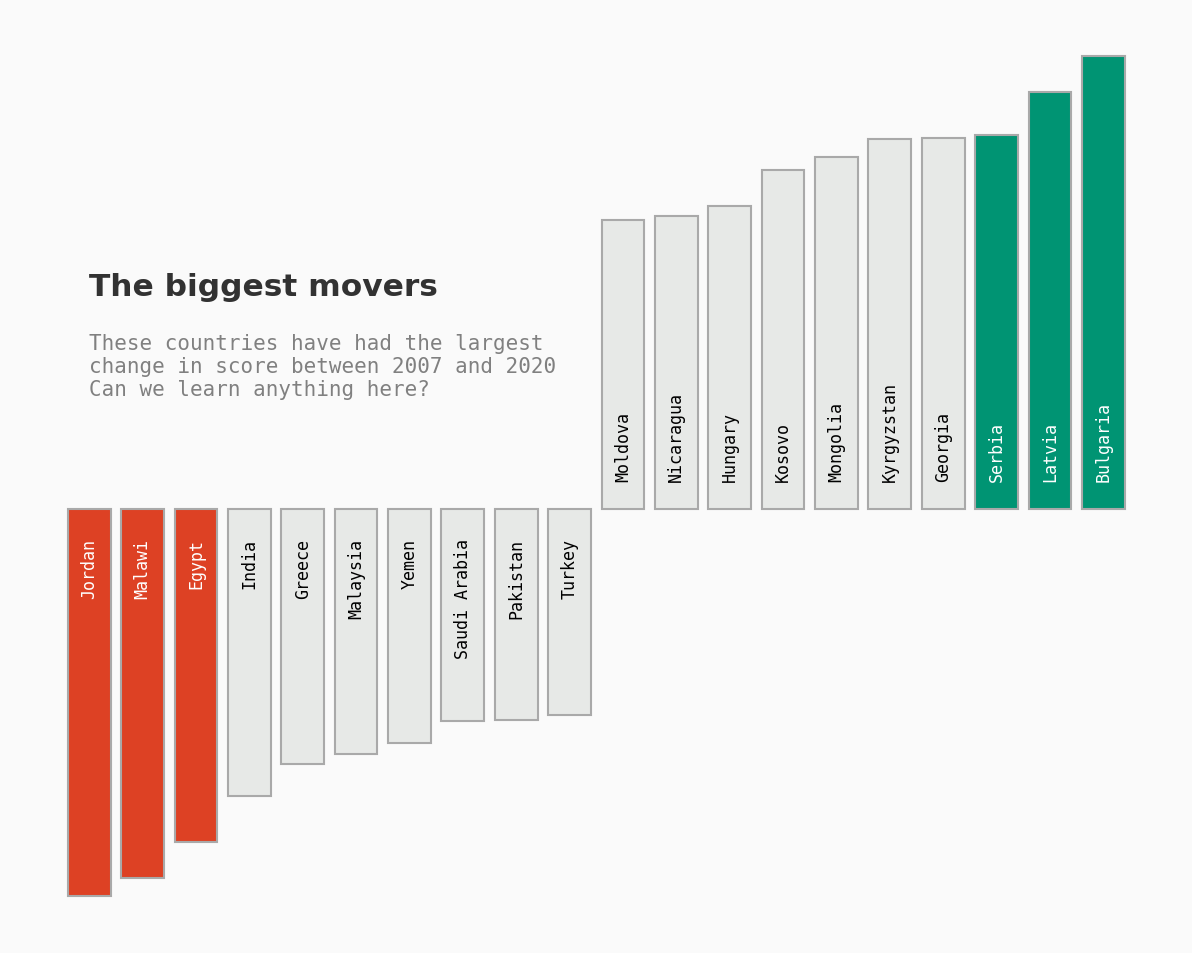

In [72]:
fig = plt.figure(figsize=(10,8),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 


# Plots 
# Happiest
data = top_changes


color_map = ['#e7e9e7' for _ in range(20)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight
color_map[17] = color_map[18] = color_map[19] =  high_c

#base
ax0.bar(data.index, data, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.bar(data.index, data, 
       edgecolor='darkgray',color=color_map)


ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])


for s in ['top','left', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    

for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, -0.1), 
                   va = 'top', ha='center',fontweight='light',fontsize=8, color='white',rotation=90)

for i in range(3,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, -0.1), 
                   va = 'top', ha='center',fontweight='light',fontsize=8, color='black',rotation=90)

    #top
for i in range(17,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, 0.1), 
                   va = 'bottom', ha='center',fontweight='light',fontsize=8, color='white',rotation=90)

for i in range(10,17):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, 0.1), 
                   va = 'bottom', ha='center',fontweight='light',fontsize=8, color='black',rotation=90)

ax0.text(0,0.75,'The biggest movers',fontfamily='sans-serif',fontsize=15,fontweight='bold',color='#323232')
ax0.text(0,0.4,'These countries have had the largest\nchange in score between 2007 and 2020\nCan we learn anything here?',fontfamily='monospace',fontsize=10,fontweight='light',color='gray')

plt.show()

In [73]:
# only top movers
top_ch_list = list(top_changes.reset_index()['Country'])

pre_post = seven.merge(twenty, on='Country', how='inner', suffixes=('_1', '_2')).reset_index()

pre_post = pre_post[pre_post['Country'].isin(top_ch_list)]
pre_post = pre_post.drop_duplicates(subset=['Country'], keep='first')



pre_post['change'] = pre_post['20_score'] - pre_post['07_score']
pre_post.sort_values(by='change')
pre_post = pre_post.set_index('Country')


fig = plt.figure(figsize=(8,6),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


value1= pre_post['07_score']
value2=pre_post['20_score']


# Reorder it following the values of the first value:
ordered_df = pre_post.sort_values(by='20_score')
my_range=range(1,len(ordered_df.index)+1)
 

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['07_score'], xmax=ordered_df['20_score'], color='lightgray', alpha=0.4)
plt.scatter(ordered_df['07_score'], my_range, color=low_c, alpha=1, ec='black',label='2007 Score',s=150)
plt.scatter(ordered_df['20_score'], my_range, color=high_c, alpha=1 , ec='black', label='2020 Score',s=150)

ax0.set_yticklabels([])
#plt.locator_params(nbins=10)

for i in range(20):
    ax0.annotate(list(ordered_df.index)[i], 
                   xy=((ordered_df[["07_score", "20_score"]].max(axis=1)[i]+0.3),i+0.6), 
                   va = 'bottom', ha='left',fontweight='light', fontfamily='monospace',fontsize=8, color='black',rotation=0)



Xstart, Xend = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(1, 10, 1))

#ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])

# Remove border from plot

for s in ['top','left', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
ax0.set_xlabel("Happiness Index Score",fontfamily='monospace',loc='left',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    
ax0.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 


L = ax0.legend(frameon=False,loc="upper center", bbox_to_anchor=(0.1, 0.65), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
#L.get_texts()[1].set_text('Outside of Europe')
#L.get_texts()[2].set_text('Europe')

ax0.text(1,20,'The biggest movers',fontfamily='sans-serif',fontsize=15,fontweight='bold',color='#323232')
ax0.text(1,14.6,
'''
Here we can see the change that these
countries underwent.

Some countries improved dramatically, 
while others have gotten significantly
unhappier since 2007
''',fontfamily='monospace',fontsize=8,fontweight='light',color='gray')

plt.show()

让我们比较在幸福指数得分方面增长最多和下降最多的两个国家：保加利亚和约旦。

我们将对比他们多年来的表现。

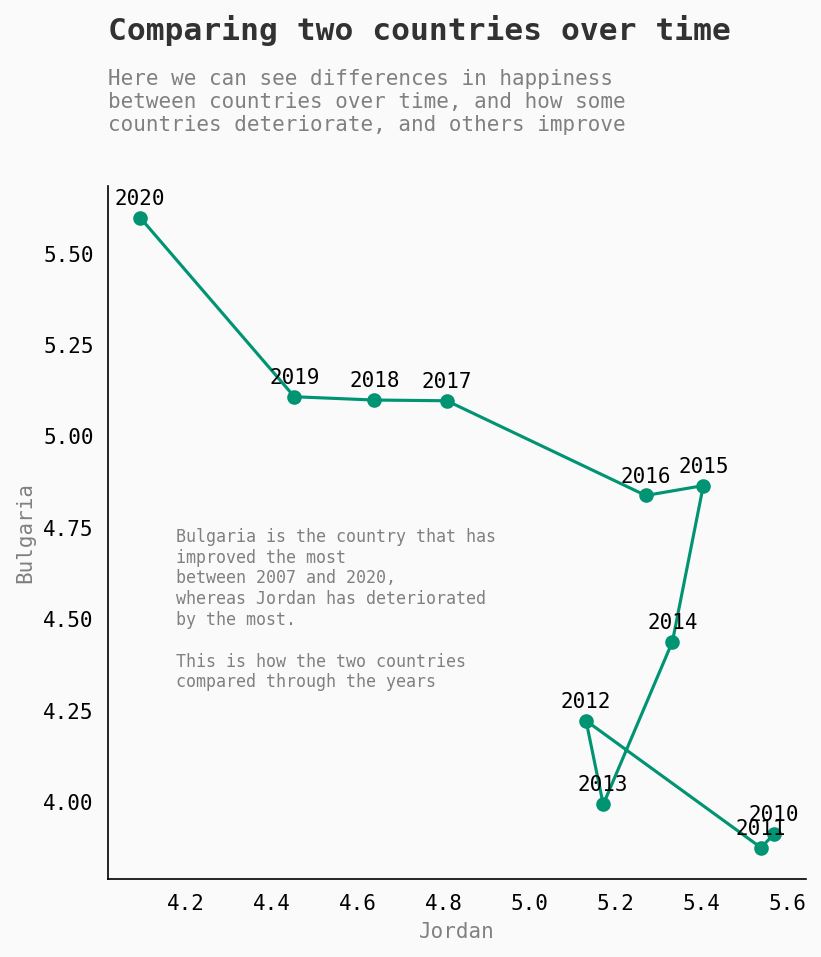

In [74]:
fig = plt.figure(figsize=(6,6),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

c1 = 'Jordan'
c2 = 'Bulgaria'

# filter data
df = df2.loc[(df2['Country']==c1) | (df2['Country']==c2)]
df = df2.loc[(df2['year']>2008)]
df = pd.pivot_table(df, values='Life Ladder', index=['year'], columns=['Country'])


# plot the connected scatterplot
plt.plot(df[c1], df[c2], '-', marker='o',color=high_c)

# add annotations in every 3 data points with a loop
for line in range(0, df.shape[0], 1):
     plt.annotate(
          df.index[line], 
          (df[c1].iloc[line], df[c2].iloc[line]+0.025) ,
          va='bottom',
          ha='center',fontfamily='monospace'
     )
        

for s in ['top','right']:
    ax0.spines[s].set_visible(False)
    
#ax0.xaxis.set_ticks(np.arange(1, 10, 1))
ax0.set_ylabel(f"{c2}",fontfamily='monospace',loc='top',color='gray')
ax0.set_xlabel(f"{c1}",fontfamily='monospace',loc='left',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    

ax0.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 


Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart,Yend+0.4,'Comparing two countries over time',fontsize=15,fontweight='bold',color='#323232')
ax0.text(Xstart,Yend+0.15,'Here we can see differences in happiness\nbetween countries over time, and how some\ncountries deteriorate, and others improve',fontsize=10,fontfamily='monospace',color='gray')

fig.text(0.2,0.3,
'''
Bulgaria is the country that has
improved the most 
between 2007 and 2020, 
whereas Jordan has deteriorated 
by the most. 

This is how the two countries
compared through the years
''',fontfamily='monospace',fontsize=8,color='gray')

# x axis label
plt.xlabel(c1)

# y axis label
plt.ylabel(c2)

# show the graph
plt.show()

当我探究这个关于时间变化的观点时，我想从大陆的角度来看。

例如，西欧的所有国家都“幸福”吗？

In [76]:
safety['bin'] = safety['Ladder score'].apply(lambda x: '0-3' if x <= 3 else '3-5' if x <= 5 else '5-7' if x <= 7 else '7+')

bin_order = ['0-3','3-5','5-7','7+']

cont_order = ['Western Europe', 'North America and ANZ',
       'Middle East and North Africa', 'Latin America and Caribbean',
       'Central and Eastern Europe', 'East Asia', 'Southeast Asia',
       'Commonwealth of Independent States', 'Sub-Saharan Africa',
       'South Asia']

safety['count'] = 1

# matrix plot

data_matrix = pd.pivot_table(safety, values='count', index=['Regional indicator'], columns=['bin'], aggfunc=np.sum).fillna(0).astype(int).loc[cont_order, bin_order].stack()

plt.rcParams["font.family"] = "monospace"

fig = plt.figure(figsize=(5, 9), dpi=150)
gs = fig.add_gridspec(5, 5)
ax0 = fig.add_subplot(gs[1:4, 0:4]) 
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

for item in cont_order[::-1]:
    for item_2 in bin_order:
        size = data_matrix[item][item_2]
        ax0.scatter(item_2, item, s=size*25, color='gray',ec='black',linewidth=1) 

#highlights
ax0.scatter(1, 1, s=650, color='#dd4124',ec='black',linewidth=1,alpha=1)    
ax0.scatter(0, 0, s=50, color='#dd4124',ec='black',linewidth=1,alpha=1) 
ax0.scatter(1, 7, s=300, color='#dd4124',ec='black',linewidth=1,alpha=1) 

ax0.scatter(3, 9, s=300, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 8, s=100, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 7, s=75, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 6, s=75, color='#009473',ec='black',linewidth=1,alpha=1) 

ax0.grid(linewidth=0.1)        
ax0.set_xticklabels(bin_order, fontsize=11, rotation=0)
plt.yticks(fontsize=11)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
ax0.text(-3,13.5,'Continental variance',fontfamily='sansserif',fontweight='bold',fontsize=17,color='#323232')
ax0.text(-3,10.3,
'''
This view helps to understand variance, and also hotspots
around the globe for both unhappy & happy nations

For example, the box shows regions with particularly
low happiness scores
''',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')    

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.set_axisbelow(True)
plt.xlabel('Happiness Score',loc='right',color='gray')


#rect

X, Y = -0.5, -0.5


ax0.add_patch(Rectangle((X, Y), 3, 4,alpha=0.2, edgecolor='gray',facecolor='gray'))
plt.show()

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
